In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
import xgboost as xgb
from scipy.stats import norm
from pyglmnet import GLM
from sklearn.preprocessing import StandardScaler

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

#%matplotlib qt5

#define custom functions:

# Define some useful modules

In [186]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [187]:
#Distribution and skewness
def distskew(dataset,feature):
    fig = plt.figure()
    sns.distplot(dataset[feature], fit=norm);
    return("Skewness = ",skew(dataset[feature].dropna()))

In [188]:
# Scatter plot
def scatplot(a,b):
    scatplotdata = pd.DataFrame({"x":a, "y":b})
    scatplotdata.plot(x = "x", y = "y", kind = "scatter")
    return()

# Import data

In [189]:
#Import data
train = pd.read_csv("D:/acads/ds/kaggle/house-price/train.csv")  #this is the initial X matrix
test = pd.read_csv("D:/acads/ds/kaggle/house-price/test.csv")

()

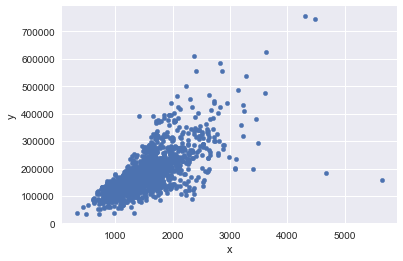

In [190]:
scatplot(train["GrLivArea"],train["SalePrice"])

C:\Users\ramie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


('Skewness = ', 4.1179773827954875)

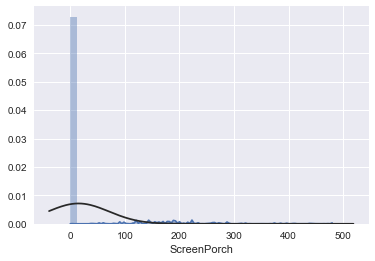

In [191]:
distskew(train,"ScreenPorch")

# Remove outliers

In [192]:
#Remove outliers
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

#train = train.drop(train[train['GrLivArea'] > 4000].index)
#train = train.drop(train[train['TotalBsmtSF'] == 0].index)

train = train.reset_index()

()

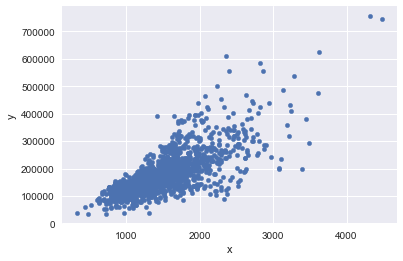

In [193]:
scatplot(train["GrLivArea"],train["SalePrice"])

In [194]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#train.loc --> loc works by looking the labels of the index
#the above operations then will extract all the data between 
#the column 'MSSubClass' and 'SaleCondition' both  included

#all_data.head() #as you can see the ID and SalePrice column disappeared 
                     
                     
                     
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
#prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#here we can list all the data by each types
#data_by_types = all_data.columns.to_series().groupby(all_data.dtypes).groups

# Some feature engineering

In [195]:
all_data["TotBsmtFin"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"]
train["TotBsmtFin"] = train["BsmtFinSF1"] + train["BsmtFinSF2"]
                 
all_data = all_data.drop("BsmtFinSF1",1)
all_data = all_data.drop("BsmtFinSF2",1)

all_data["TotBath"] = all_data["FullBath"] + 0.5*all_data["HalfBath"] + all_data["BsmtFullBath"] + 0.5*all_data["BsmtHalfBath"]
train["TotBath"] = train["FullBath"] + 0.5*train["HalfBath"] + train["BsmtFullBath"] + 0.5*train["BsmtHalfBath"]

all_data = all_data.drop("FullBath",1)
all_data = all_data.drop("HalfBath",1)
all_data = all_data.drop("BsmtFullBath",1)
all_data = all_data.drop("BsmtHalfBath",1)    

In [196]:
# Create a new feature to handle the zero values of TotalBsmtSF
#all_data["ZeroBsmt"] = 0
#all_data.loc[all_data["TotalBsmtSF"] == 0,"ZeroBsmt"] = 1

In [197]:
#avgTotalBsmtSF = all_data["TotalBsmtSF"].mean()
#all_data.loc[all_data["TotalBsmtSF"] == 0,"TotalBsmtSF"] = avgTotalBsmtSF

In [198]:
# Add the living areas and basement aread to create a new feature TotArea
all_data["TotArea"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
train["TotArea"] = train["GrLivArea"] + train["TotalBsmtSF"]

# Take log of the skewed features

In [199]:
#get the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index



#for all the numeric features, calculate the skewness
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#exctract the features with skewness higher than 75%
skewed_feats = skewed_feats[skewed_feats > 0.1]
skewed_feats = skewed_feats.index

#log transform skewed numeric features with skewness > 75%:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

train[skewed_feats] = np.log1p(train[skewed_feats])

# Drop some features that do not help

In [200]:
all_data = all_data.drop("BsmtFinType1",1)
all_data = all_data.drop("2ndFlrSF",1)
all_data = all_data.drop("BedroomAbvGr",1)

all_data = all_data.drop("LowQualFinSF",1)
all_data = all_data.drop("3SsnPorch",1)
#all_data = all_data.drop("PoolArea",1)

#all_data = all_data.drop("GrLivArea",1)
#all_data = all_data.drop("TotalBsmtSF",1)


# Process data

In [201]:
dummies = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data)

#pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

# Normalize the features (this does not seem to help: increases error)
#all_data = all_data.apply(lambda x: x/np.sqrt(sum(x**2)))

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [202]:
#distskew(all_data,"ScreenPorch")

()

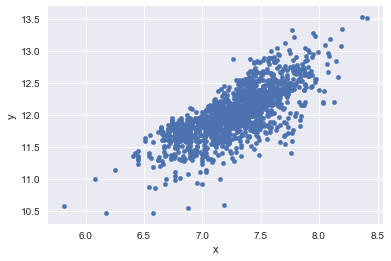

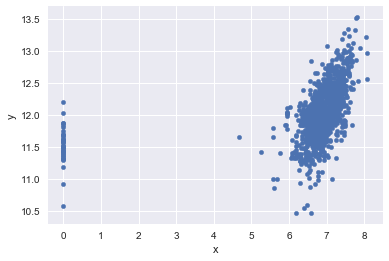

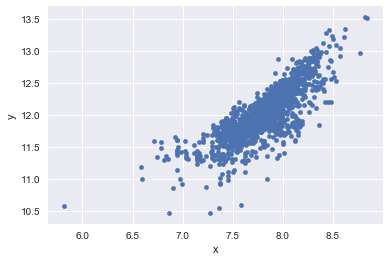

In [203]:
scatplot(train["GrLivArea"],train["SalePrice"])
scatplot(train["TotalBsmtSF"],train["SalePrice"])
scatplot(train["TotArea"],train["SalePrice"])


# Fit model: Ridge

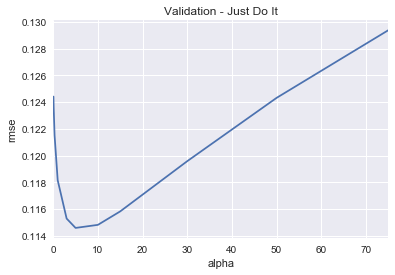

The min value of Ridge is  0.114592348143


In [204]:
#first evaluation of the regular linear regression method:
#Ridge:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
           for alpha in alphas]
    
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()
print("The min value of Ridge is ",cv_ridge.min())

In [205]:
# Now fit Ridge model
model_ridge = Ridge(alpha = 5).fit(X_train, y)

# Fit model: Lasso

C:\Users\ramie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


('Skewness = ', -0.46467858159899245)

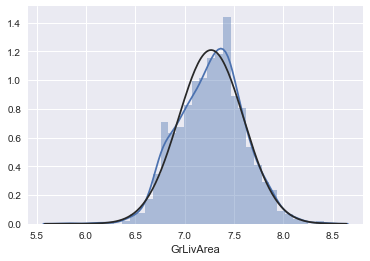

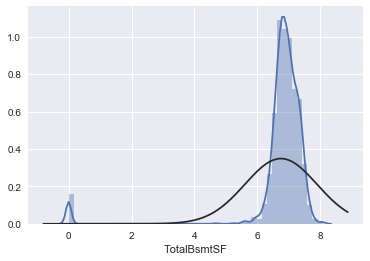

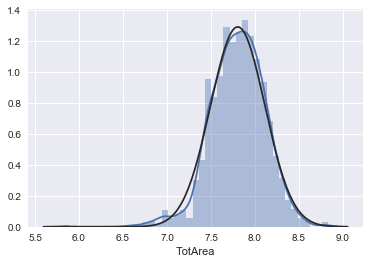

In [206]:
distskew(X_train,"GrLivArea")
distskew(X_train,"TotalBsmtSF")
distskew(X_train,"TotArea")

The min value of Lasso is  0.11070347958
Lasso picked 98 variables and eliminated the other 176 variables


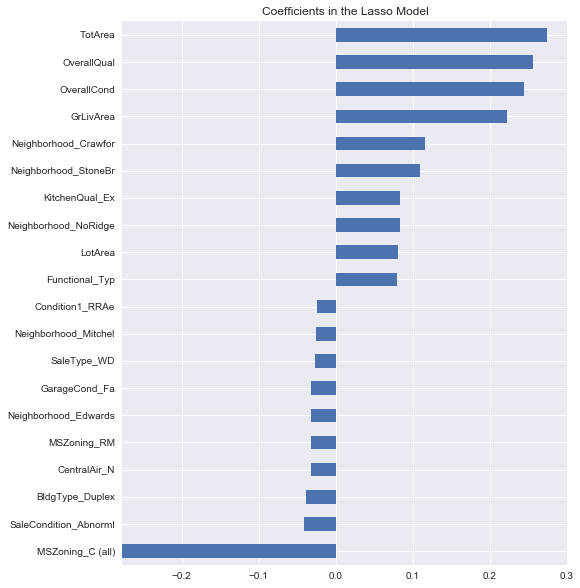

In [207]:
#Lasso:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())


#Lasso choose performs also feature selection 

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#Let's look to the most important coefficients:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")  
plt.show()  

#Also note that unlike the feature importance you'd get from a random forest 
#these are actual coefficients in your model - so you can say precisely 
#why the predicted price is what it is. 
#The only issue here is that we log_transformed both the target 
#and the numeric features 
#so the actual magnitudes are a bit hard to interpret.


#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds_log = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
#let's return to "original" value from the log:
preds_val = np.expm1(preds_log)

#solution = pd.DataFrame({"id":test.Id, "SalePrice":preds_val})
#solution.to_csv("MDV_Lasso_v1.csv", index = False)


preds_log["residuals"] = preds_log["true"] - preds_log["preds"]



#preds_log.plot(x = "preds", y = "true",kind = "scatter")
#plt.title('Log Value ')
#plt.show()

#
#preds_val["residuals"] = preds_val["true"] - preds_val["preds"]
#preds_val.plot(x = "preds", y = "residuals",kind = "scatter")
#plt.title('Original Value in $')
#plt.show()

# Fit model: XGBoost

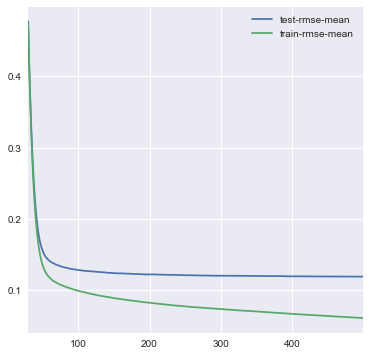

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [208]:
#Let's add an xgboost model to our linear model to see 
#if we can improve our score:

#y = preds_log["residuals"]
    
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

#the params were tuned using xgb.cv
model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.1) 
model_xgb.fit(X_train, y)

# Now fit GLM net model

In [209]:
#model_glm = GLM(distr='gaussian')
#scaler1 = StandardScaler().fit(X_train)
#scaler2 = StandardScaler().fit(X_test)
#model_glm.fit(scaler1.transform(X_train), y)



# Now combine the models for final prediction

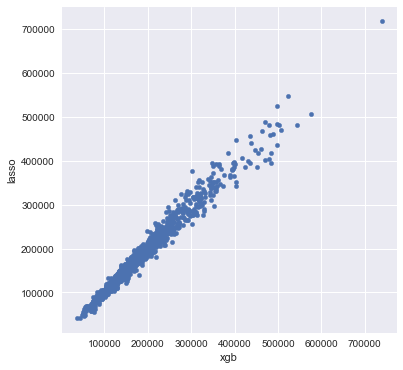

In [210]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
ridge_preds = np.expm1(model_ridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))
glm_preds = np.expm1(model_glm.predict(scaler2.transform(X_test)))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
plt.show()

#Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves 
#the score although in this case it doesn't help that much.

preds = 0.30*lasso_preds + 0.30*lasso_preds + 0.40*xgb_preds

solution = pd.DataFrame({"SalePrice":preds,"id":test.Id})

solution.to_csv("D:/acads/ds/kaggle/house-price/my_solution_eight.csv", index = False)

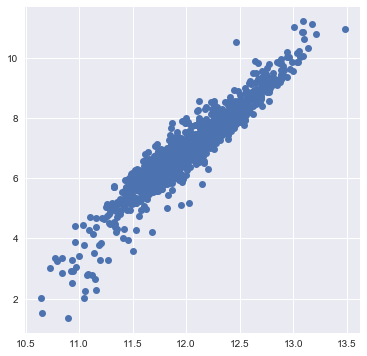

In [211]:
plt.plot(model_lasso.predict(X_test), model_ridge.predict(scaler2.transform(X_test)), 'o', label='original data')

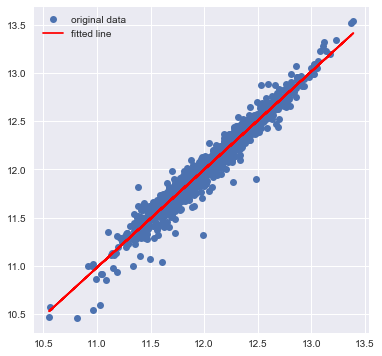

r-squared: 0.95372482383


In [212]:
x = 0.30*model_lasso.predict(X_train) + 0.30*model_ridge.predict(X_train) + 0.40*model_xgb.predict(X_train)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()
print("r-squared:", r_value**2)